In [1031]:
import os
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
import math

from keras.models import Sequential
from keras.layers import LSTM, Dense

pd.set_option('display.max_rows', 200)
pd.set_option('display.max_columns', 200)

os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

In [1032]:
def quartersToHours(data):
    data['date_forecast'] = pd.to_datetime(data['date_forecast'], format='%Y-%m.%d %H:%M:%S')
    data["year"] = data['date_forecast'].dt.year
    data["month"] = data['date_forecast'].dt.month
    data["day"] = data['date_forecast'].dt.day
    data["hour"] = data['date_forecast'].dt.hour


    group = data.groupby([data["year"], data["month"], data["day"], data["hour"]])  
    result = group.mean()
    result = result.reset_index()
    
    return_df = result.drop(['year','month', 'day', 'hour'], axis=1)
    
    return return_df

In [1033]:
def join_data_and_labels(train, val, labels):
    
    #Remove hour and minute values
    val = val.assign(date_forecast=val.date_forecast.dt.round('H'))
    train = train.assign(date_forecast=train.date_forecast.dt.round('H'))
    
    #rename columns names to match
    
    train = train.rename(columns={'date_forecast': 'date'})
    val = val.rename(columns={'date_forecast': 'date'})
    labels = labels.rename(columns={'time': 'date'})
    
    joined_train = pd.merge(train, labels, how="inner", on="date")
    joined_val = pd.merge(val, labels, how="inner", on="date")

    
    return joined_train, joined_val

In [1034]:
def remove_unused_columns(df):
    df = df.drop(['wind_speed_10m:ms', 'elevation:m', 'wind_speed_u_10m:ms', 'wind_speed_v_10m:ms',
                 'wind_speed_w_1000hPa:ms'], axis=1)
    return df

In [1035]:
def drop_constanst_columns(train, val, test):
    constanst_columns = []
    # Remove constants
    for key, value in test.std().items():
        if value == 0.0:
            constanst_columns.append(key)

    train.drop(constanst_columns, axis=1,inplace=True)
    val.drop(constanst_columns, axis=1,inplace=True)
    test.drop(constanst_columns, axis=1,inplace=True)

In [1036]:
def convert_date_to_sin_and_cos(df):
    day = 24*60*60 #seconds in a day
    year = (365.2425)*day #seconds in a year
    month = year / 12.0

    date_time = pd.to_datetime(df.pop('date'), format='%Y-%m.%d %H:%M:%S')
    
    timestamp_s = date_time.map(pd.Timestamp.timestamp)

    #df['Month sin'] = np.sin(timestamp_s * (2 * np.pi / month))
    #df['Month cos'] = np.cos(timestamp_s * (2 * np.pi / month))
    
    df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
    df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))
    
    df['Hour sin'] = np.sin(timestamp_s * (2 * np.pi / day))
    df['Hour cos'] = np.cos(timestamp_s * (2 * np.pi / day))
   

In [1037]:
def round_is_day(df):
    df["is_day:idx"] = [round(df["is_day:idx"][i]) for i in range(len(df))]
    df["is_in_shadow:idx"] = [round(df["is_in_shadow:idx"][i]) for i in range(len(df))]
    

In [1038]:
def normalize_except_columns(df):
    not_to_be_norm = ["is_day:idx", 'is_in_shadow:idx', 'Hour sin', 'Hour cos',"Year sin", "Year cos"]
    cols = df.columns.tolist()
    cols_to_norm = [i for i in cols if i not in not_to_be_norm]
    
    df[cols_to_norm] = df[cols_to_norm].apply(lambda x: (x - x.min()) / (x.max() - x.min()))


In [1039]:
train_a = pd.read_parquet('dataset/A/train_targets.parquet')
train_b = pd.read_parquet('dataset/B/train_targets.parquet')
train_c = pd.read_parquet('dataset/C/train_targets.parquet')

In [1040]:
a_max = train_a["pv_measurement"].max()
b_max = train_b["pv_measurement"].max()
c_max = train_c["pv_measurement"].max()

In [1041]:
#Load data, sample to hours and drop columns which are not needed
X_train_observed_a = quartersToHours(pd.read_parquet('dataset/A/X_train_observed.parquet')) #Train_x
X_train_observed_b = quartersToHours(pd.read_parquet('dataset/B/X_train_observed.parquet'))
X_train_observed_c = quartersToHours(pd.read_parquet('dataset/C/X_train_observed.parquet'))

X_train_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_train_estimated.parquet')) # Val_x
X_train_estimated_a = X_train_estimated_a.drop(["date_calc"], axis=1)

X_train_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_train_estimated.parquet'))
X_train_estimated_b = X_train_estimated_b.drop(["date_calc"], axis=1)

X_train_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_train_estimated.parquet'))
X_train_estimated_c = X_train_estimated_c.drop(["date_calc"], axis=1)

X_test_estimated_a = quartersToHours(pd.read_parquet('dataset/A/X_test_estimated.parquet'))
X_test_estimated_a = X_test_estimated_a.drop(["date_calc"], axis=1)
test_a = X_test_estimated_a.rename(columns={'date_forecast': 'date'})

X_test_estimated_b = quartersToHours(pd.read_parquet('dataset/B/X_test_estimated.parquet'))
X_test_estimated_b = X_test_estimated_b.drop(["date_calc"], axis=1)
test_b = X_test_estimated_b.rename(columns={'date_forecast': 'date'})

X_test_estimated_c = quartersToHours(pd.read_parquet('dataset/C/X_test_estimated.parquet'))
X_test_estimated_c = X_test_estimated_c.drop(["date_calc"], axis=1)
test_c = X_test_estimated_c.rename(columns={'date_forecast': 'date'})

In [1042]:
# Join data and labels into one df
train_data_a, val_data_a = join_data_and_labels(X_train_observed_a, X_train_estimated_a, train_a)
train_data_b, val_data_b = join_data_and_labels(X_train_observed_b, X_train_estimated_b, train_b)
train_data_c, val_data_c = join_data_and_labels(X_train_observed_c, X_train_estimated_c, train_c)

In [1043]:
# Remove columns which are not needed
train_data_a = remove_unused_columns(train_data_a)
val_data_a = remove_unused_columns(val_data_a)
test_a = remove_unused_columns(test_a)

train_data_b = remove_unused_columns(train_data_b)
val_data_b = remove_unused_columns(val_data_b)
test_b = remove_unused_columns(test_b)

train_data_c = remove_unused_columns(train_data_c)
val_data_c = remove_unused_columns(val_data_c)
test_c = remove_unused_columns(test_c)

In [1044]:
# Convert date into sin and cos components
convert_date_to_sin_and_cos(train_data_a)
convert_date_to_sin_and_cos(val_data_a)
convert_date_to_sin_and_cos(test_a)

convert_date_to_sin_and_cos(train_data_b)
convert_date_to_sin_and_cos(val_data_b)
convert_date_to_sin_and_cos(test_b)

convert_date_to_sin_and_cos(train_data_c)
convert_date_to_sin_and_cos(val_data_c)
convert_date_to_sin_and_cos(test_c)

In [1045]:
# Isday should be a binary value
round_is_day(train_data_a)
round_is_day(val_data_a)
round_is_day(test_a)

round_is_day(train_data_b)
round_is_day(val_data_b)
round_is_day(test_b)

round_is_day(train_data_c)
round_is_day(val_data_c)
round_is_day(test_c)

In [1046]:
normalize_except_columns(train_data_a)
normalize_except_columns(val_data_a)
normalize_except_columns(test_a)

normalize_except_columns(train_data_b)
normalize_except_columns(val_data_b)
normalize_except_columns(test_b)

normalize_except_columns(train_data_c)
normalize_except_columns(val_data_c)
normalize_except_columns(test_c)

In [1047]:
# Fill 0 for NaNs
train_data_a = train_data_a.fillna(0)
val_data_a = val_data_a.fillna(0)
test_a = test_a.fillna(0)

train_data_b = train_data_b.fillna(0)
val_data_b = val_data_b.fillna(0)
test_b = test_b.fillna(0)

train_data_c = train_data_c.fillna(0)
val_data_c = val_data_c.fillna(0)
test_c = test_c.fillna(0)

In [1048]:
# Drop columns which are constant
drop_constanst_columns(train_data_a, val_data_a, test_a)
drop_constanst_columns(train_data_b, val_data_b, test_b)
drop_constanst_columns(train_data_c, val_data_c, test_c)

In [1049]:
train_data_c = train_data_c[5800:]
train_data_b.drop(index=train_data_b.iloc[13410:14460].index.tolist(), axis=0, inplace=True)

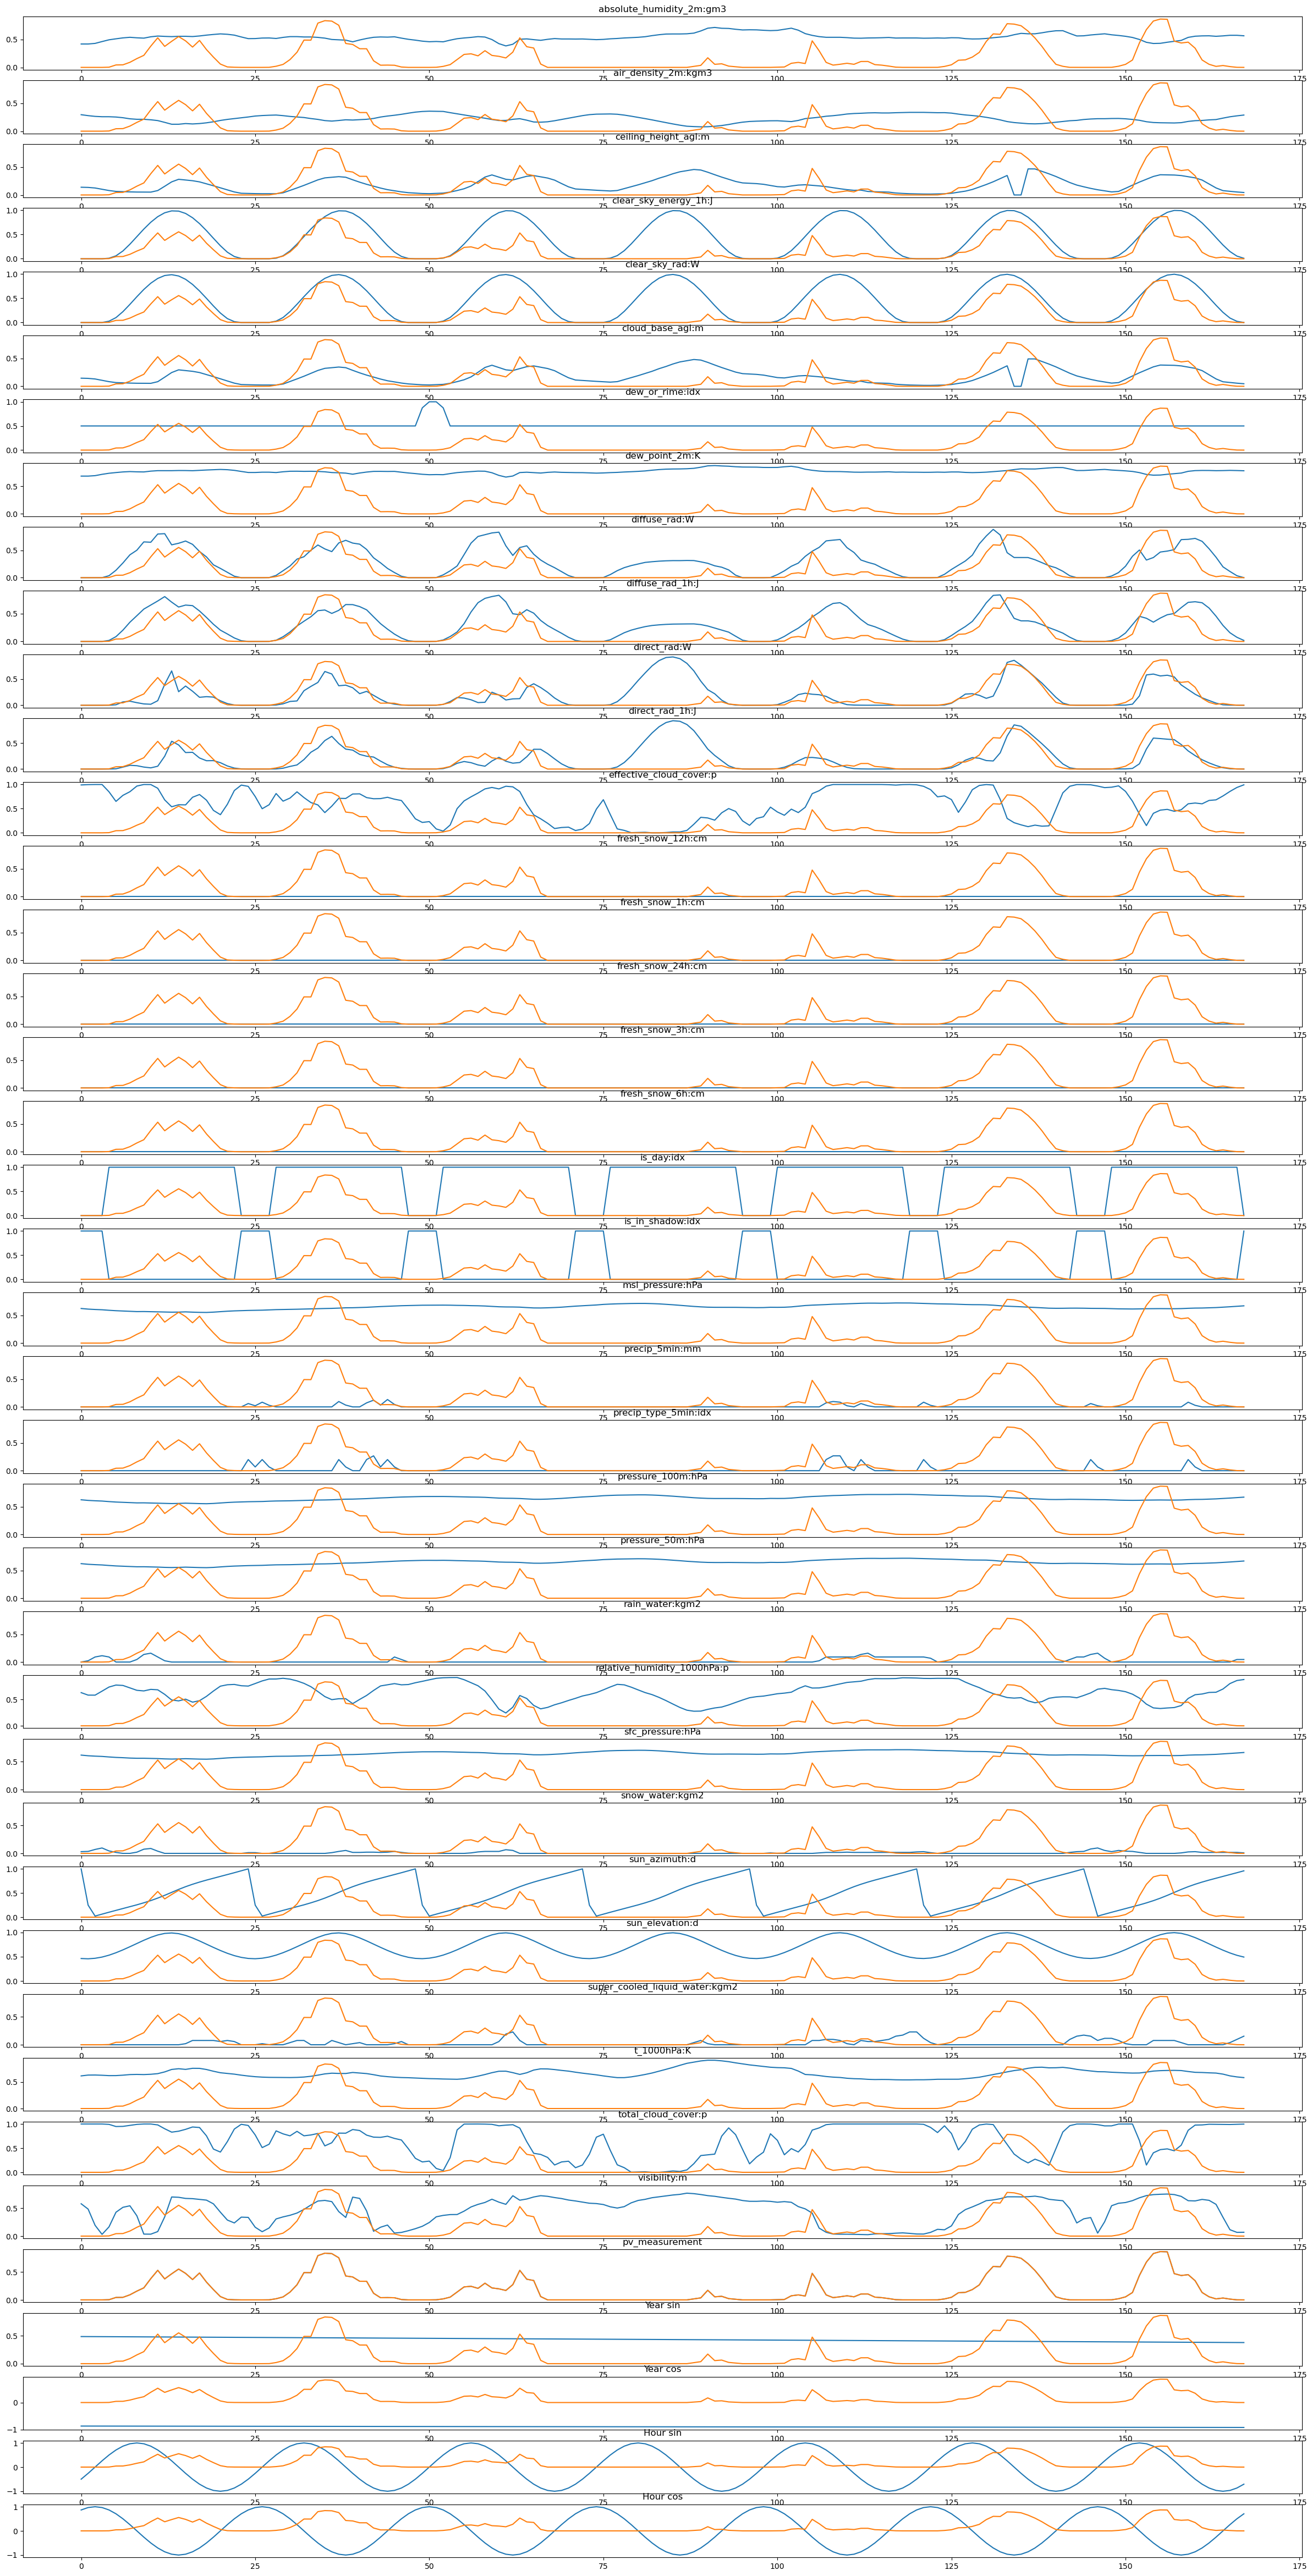

In [1050]:

#plt.figure(figsize=(30,20))
cols = train_data_a.columns.tolist()
fig, axs = plt.subplots(len(cols), figsize=(30, 60))
#plt.ylim(0, 1)
for i, col in enumerate(cols):
    axs[i].set_title(col)
    axs[i].plot(train_data_a[col][0:24*7], label=col)
    axs[i].plot(train_data_a["pv_measurement"][0:24*7], label=col)

#legend = plt.legend(loc='upper left', shadow=True, fontsize='x-large')


#plt.plot(train_data_a["pv_measurment"])

In [1051]:
MAX_EPOCHS = 20

def compile_and_fit(model, train_x, train_y, val_x, val_y, patience=3):
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=3,
                                                    mode='min',
                                                    restore_best_weights=True)

    model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.RMSprop(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

    history = model.fit(x= train_x, y=train_y, epochs=MAX_EPOCHS,
                      validation_data=(val_x, val_y),
                       callbacks=[early_stopping])
    return history

In [1052]:
def split_and_batch(df):
    df_labels = df.pop("pv_measurement")
    
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)
    df_label_arr = np.array(df_labels, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)
        label_3d = df_label_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d, label_3d

In [1053]:
def batch(df):
    BATCH_SIZE=30

    df_arr = np.array(df, dtype=np.float32)

    # Calculate the number of batches needed
    num_batches = df_arr.shape[0] // BATCH_SIZE

    # Reshape the 2D array into a 3D array with shape (num_batches, BATCH_SIZE, 48)
    if df_arr.shape[0] % BATCH_SIZE == 0:
        # If the data size is a multiple of BATCH_SIZE
        data_3d = df_arr.reshape(num_batches, BATCH_SIZE, -1)

    else:
        # If there's some remaining data that doesn't fit perfectly into batches
        remaining_rows = df_arr.shape[0] % BATCH_SIZE
        data_3d = df_arr[:-remaining_rows].reshape(num_batches, BATCH_SIZE, -1)

    return data_3d
    

In [1054]:
train_a_x, train_a_y = split_and_batch(train_data_a)
val_a_x, val_a_y = split_and_batch(val_data_a)

train_b_x, train_b_y = split_and_batch(train_data_b)
val_b_x, val_b_y = split_and_batch(val_data_b)

train_c_x, train_c_y = split_and_batch(train_data_c)
val_c_x, val_c_y = split_and_batch(val_data_c)

test_a = batch(test_a)
test_b = batch(test_b)
test_c = batch(test_c)

In [1055]:
lstm_model_a = tf.keras.models.Sequential([ 
    #tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(60, return_sequences=True, kernel_initializer=tf.keras.initializers.GlorotNormal(),
                    bias_initializer='zeros')
    ),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True, dropout=0.5)
    ),
    #tf.keras.layers.LSTM(64, return_sequences=True),
    #tf.keras.layers.Dense(units=48),
    #tf.keras.layers.Dense(units=32),

    tf.keras.layers.Dense(units=1, activation="relu")
])

lstm_model_b = tf.keras.models.clone_model(lstm_model_a)
lstm_model_c = tf.keras.models.clone_model(lstm_model_b)

In [1056]:
history_a = compile_and_fit(lstm_model_a,train_a_x, train_a_y, val_a_x, val_a_y)
print(f'measure a: {lstm_model_a.evaluate(val_a_x, val_a_y)}')

#[0.0038667283952236176, 0.024362364783883095]

Epoch 1/20
31/31 [==============================] - 16s 146ms/step - loss: 0.0278 - mean_absolute_error: 0.0793 - val_loss: 0.0052 - val_mean_absolute_error: 0.0299
Epoch 2/20
31/31 [==============================] - 2s 75ms/step - loss: 0.0127 - mean_absolute_error: 0.0564 - val_loss: 0.0044 - val_mean_absolute_error: 0.0257
Epoch 3/20
31/31 [==============================] - 2s 74ms/step - loss: 0.0100 - mean_absolute_error: 0.0497 - val_loss: 0.0080 - val_mean_absolute_error: 0.0353
Epoch 4/20
31/31 [==============================] - 2s 73ms/step - loss: 0.0093 - mean_absolute_error: 0.0479 - val_loss: 0.0038 - val_mean_absolute_error: 0.0235
Epoch 5/20
31/31 [==============================] - 2s 75ms/step - loss: 0.0084 - mean_absolute_error: 0.0450 - val_loss: 0.0043 - val_mean_absolute_error: 0.0264
Epoch 6/20
31/31 [==============================] - 2s 74ms/step - loss: 0.0081 - mean_absolute_error: 0.0445 - val_loss: 0.0040 - val_mean_absolute_error: 0.0247
Epoch 7/20
5/5 [====

In [1057]:
history_b = compile_and_fit(lstm_model_b,train_b_x, train_b_y, val_b_x, val_b_y)
print(f'measure b: {lstm_model_b.evaluate(val_b_x, val_b_y)}')

# [0.003871380351483822, 0.023782264441251755]

Epoch 1/20
30/30 [==============================] - 17s 146ms/step - loss: 0.0285 - mean_absolute_error: 0.0749 - val_loss: 0.0059 - val_mean_absolute_error: 0.0288
Epoch 2/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0099 - mean_absolute_error: 0.0465 - val_loss: 0.0096 - val_mean_absolute_error: 0.0362
Epoch 3/20
30/30 [==============================] - 2s 71ms/step - loss: 0.0088 - mean_absolute_error: 0.0443 - val_loss: 0.0110 - val_mean_absolute_error: 0.0393
Epoch 4/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0081 - mean_absolute_error: 0.0417 - val_loss: 0.0036 - val_mean_absolute_error: 0.0231
Epoch 5/20
30/30 [==============================] - 2s 72ms/step - loss: 0.0074 - mean_absolute_error: 0.0404 - val_loss: 0.0129 - val_mean_absolute_error: 0.0422
Epoch 6/20
30/30 [==============================] - 2s 74ms/step - loss: 0.0066 - mean_absolute_error: 0.0381 - val_loss: 0.0059 - val_mean_absolute_error: 0.0284
Epoch 7/20
4/4 [====

In [1058]:
history_c = compile_and_fit(lstm_model_c,train_c_x, train_c_y, val_c_x, val_c_y)
print(f'measure c: {lstm_model_c.evaluate(val_c_x, val_c_y)}')

#[0.0031701738480478525, 0.023126540705561638]

Epoch 1/20
25/25 [==============================] - 16s 160ms/step - loss: 0.0287 - mean_absolute_error: 0.0716 - val_loss: 0.0045 - val_mean_absolute_error: 0.0263
Epoch 2/20
25/25 [==============================] - 2s 74ms/step - loss: 0.0089 - mean_absolute_error: 0.0427 - val_loss: 0.0094 - val_mean_absolute_error: 0.0396
Epoch 3/20
25/25 [==============================] - 2s 72ms/step - loss: 0.0081 - mean_absolute_error: 0.0404 - val_loss: 0.0035 - val_mean_absolute_error: 0.0244
Epoch 4/20
25/25 [==============================] - 2s 71ms/step - loss: 0.0067 - mean_absolute_error: 0.0369 - val_loss: 0.0030 - val_mean_absolute_error: 0.0222
Epoch 5/20
25/25 [==============================] - 2s 71ms/step - loss: 0.0059 - mean_absolute_error: 0.0343 - val_loss: 0.0082 - val_mean_absolute_error: 0.0399
Epoch 6/20
25/25 [==============================] - 2s 71ms/step - loss: 0.0059 - mean_absolute_error: 0.0341 - val_loss: 0.0024 - val_mean_absolute_error: 0.0200
Epoch 7/20
25/25 [==

In [1059]:
#lstm_model_a.get_weight_paths()

In [1070]:
pred_a = lstm_model_a.predict(test_a)
pred_b = lstm_model_b.predict(test_b)
pred_c = lstm_model_c.predict(test_c)

pred_a_val = lstm_model_a.predict(val_a_x)
pred_b_val = lstm_model_b.predict(val_b_x)
pred_c_val = lstm_model_c.predict(val_c_x)

pred_a_train = lstm_model_a.predict(train_a_x)
pred_b_train = lstm_model_b.predict(train_b_x)
pred_c_train = lstm_model_c.predict(train_c_x)

25/25 [==============================] - 1s 21ms/step


In [1071]:
pred_a = pred_a.flatten() * a_max / pred_a.max()
pred_b = pred_b.flatten() * b_max / pred_b.max()
pred_c = pred_c.flatten() * c_max / pred_c.max()

pred_a_val = pred_a_val.flatten() * a_max / pred_a_val.max()
pred_b_val = pred_b_val.flatten() * b_max / pred_b_val.max()
pred_c_val = pred_c_val.flatten() * c_max / pred_c_val.max()

pred_a_train = pred_a_train.flatten() * a_max / pred_a_train.max()
pred_b_train = pred_b_train.flatten() * b_max / pred_b_train.max()
pred_c_train = pred_c_train.flatten() * c_max / pred_c_train.max()

In [1073]:
#lstm_model_a.save("./a_2.keras")
#lstm_model_b.save("./b_2.keras")
#lstm_model_c.save("./c_2.keras")

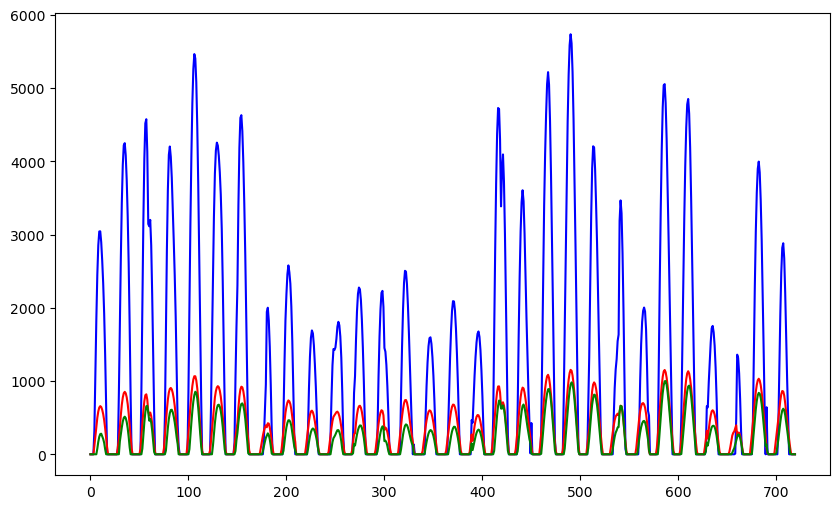

In [1075]:
plt.figure(figsize=(10,6))
plt.plot(pred_a, color="blue")
plt.plot(pred_b, color="red")
plt.plot(pred_c, color="green")

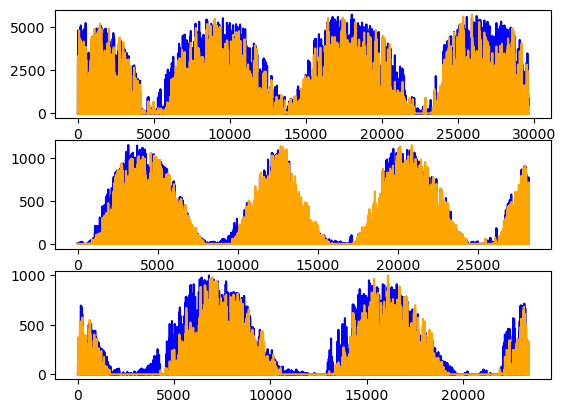

In [1076]:

fig, axs = plt.subplots(3)

axs[0].plot(train_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_train, color="orange")

axs[1].plot(train_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_train, color="orange")

axs[2].plot(train_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_train, color="orange")

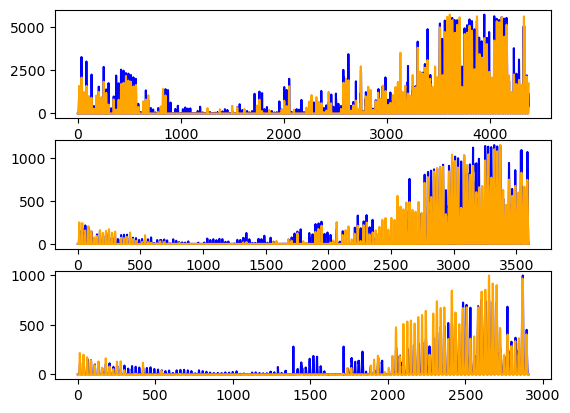

In [1077]:
fig, axs = plt.subplots(3)

axs[0].plot(val_a_y.flatten() * a_max, color="blue")
axs[0].plot(pred_a_val, color="orange")

axs[1].plot(val_b_y.flatten() * b_max, color="blue")
axs[1].plot(pred_b_val, color="orange")

axs[2].plot(val_c_y.flatten() * c_max, color="blue")
axs[2].plot(pred_c_val, color="orange")

In [1078]:
test = pd.read_csv('test.csv')

test

,id,time,prediction,location
0,0,2023-05-01 00:00:00,0,A
1,1,2023-05-01 01:00:00,0,A
2,2,2023-05-01 02:00:00,0,A
3,3,2023-05-01 03:00:00,0,A
4,4,2023-05-01 04:00:00,0,A
...,...,...,...,...
2155,2155,2023-07-03 19:00:00,0,C
2156,2156,2023-07-03 20:00:00,0,C
2157,2157,2023-07-03 21:00:00,0,C
2158,2158,2023-07-03 22:00:00,0,C


In [1079]:
sample_submission = pd.read_csv('sample_submission.csv')
sample_submission

,id,prediction
0,0,0
1,1,0
2,2,0
3,3,0
4,4,0
...,...,...
2155,2155,0
2156,2156,0
2157,2157,0
2158,2158,0


In [1080]:
submit = np.concatenate((np.concatenate((pred_a, pred_b)),pred_c))

In [1081]:
from datetime import datetime

now = datetime.now() # current date and time

# Example, let the predictions be random values
test['prediction'] = submit
sample_submission = sample_submission[['id']].merge(test[['id', 'prediction']], on='id', how='left')
sample_submission.to_csv("bi_vol7.csv", index=False)